In [29]:
# import
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math

# Problem Undersanding: 

## 任务介绍：
1. MoA是什么？Mechanism of Action,药物可以产生药理学效果的生化反应，对于给定的分子对其生物活性进行描述。
2. 如何确定药物的MoAs？一般的方法是对人体细胞使用药物，然后分析细胞的反应，在大型基因组数据库中寻找具有相似模式的已知的MoAs。如药物的基因表达或细胞活力模式的数据库。本比赛给出在100种不同的细胞种类上使用新的技术测量进行同步测量出的人体细胞对药物的反应，包含gene expression 和 cell viability patterns等特征,数据库中包含超过5000种药物的MoA标签。每种药物具有多个MoA标签。<a> 

## 数据文件
sample_submission.csv：测试集提交格式。(3982, 207)--3982个实例，对206个类别预测得到的概率。    
test_features.csv：测试集特征。 (3982, 876)--3982个实例，875个特征，用于模型进行预测。  
train_features.csv：训练集特征。(23814, 876)--23814个实例，875个特征，用于训练模型。  
train_targets_nonscored.csv：训练集中测试集不需要进行预测的MoA类别文件。每列都是一个样本对应的MoA类别，但是这些类别在测试集中是不需要预测的。(23814, 403)--23814个实例的402个MoA的标签值。    
train_targets_scored.csv：训练集MoA类别标签。(23814, 207)--23814个实例的206个类别的标签值。 
train_drug:只包含训练集每个实例对应的drugs

In [2]:
# Read in the data
INPUT_DIR = './data/lish-moa'

ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
test_ft = pd.read_csv(f'{INPUT_DIR}/test_features.csv')
train_ft = pd.read_csv(f'{INPUT_DIR}/train_features.csv')
train_targets_nonscored = pd.read_csv(f'{INPUT_DIR}/train_targets_nonscored.csv')
train_targets_scored = pd.read_csv(f'{INPUT_DIR}/train_targets_scored.csv')
train_drugs = pd.read_csv(f'{INPUT_DIR}/train_drug.csv')

In [3]:
l = [ss,test_ft,train_ft,train_targets_nonscored,train_targets_scored,train_drugs]
for i in l:
    print(i.shape)

(3982, 207)
(3982, 876)
(23814, 876)
(23814, 403)
(23814, 207)
(23814, 2)


<b>sample_submission:    sig_id为实例ID，其余206列为206个MoA类别。

In [9]:
ss.head(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [14]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Columns: 207 entries, sig_id to wnt_inhibitor
dtypes: float64(206), object(1)
memory usage: 6.3+ MB


<b>test_features:sig_id为实例ID,其余875列为实例的特征

In [10]:
test_ft.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.384,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942


In [15]:
test_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 26.6+ MB


<b>train_features:sig_id为实例ID, 其余为实例的875个特征

In [11]:
train_ft.head(3)  

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


In [16]:
train_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


<b>train_targets_nonscored：sig_id为实例ID,其余为实例的402个不算分数的MoA类别的标签值

In [12]:
train_targets_nonscored.head(3)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
train_targets_nonscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 403 entries, sig_id to xiap_inhibitor
dtypes: int64(402), object(1)
memory usage: 73.2+ MB


<b>train_targets_scored:sig_id为实例ID,其余为206个要预测的MoA类别的标签值

In [13]:
train_targets_scored.head(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train_targets_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 207 entries, sig_id to wnt_inhibitor
dtypes: int64(206), object(1)
memory usage: 37.6+ MB


<b>train_drugs</b>  
sig_id:表示训练实例的标识，与train_feat中的sig_id对应  
drug_id:每个实例对应的他属于的drug_id。  
训练集中的药物种类包含3289中，由于介绍中说明了数据一共有5000种drugs，所以测试集中有1711种没有在训练集中出现的药物种类。

In [5]:
train_drugs.shape

(23814, 2)

In [4]:
train_drugs.head(3)

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c


In [7]:
len(train_drugs.drug_id.unique())

3289

# Metric Undesanding:  

使用Log loss对预测结果进行评估
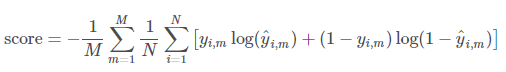

In [1]:
from sklearn.metrics import log_loss

In [37]:
def logloss(label,pred,clip=False,eps=1e-15):
    if clip:
        pred = np.clip(pred, eps, 1 - eps)
    if label==1:
        return -np.log(pred)
    else:
        return -np.log(1 - pred)

In [46]:
print(logloss(1,0.9),logloss(1,0.5),logloss(1,0.1))
print(logloss(1,0.9,True),logloss(1,0.5,True),logloss(1,0.1,True))

0.10536051565782628 0.6931471805599453 2.3025850929940455
0.10536051565782628 0.6931471805599453 2.3025850929940455


In [56]:
print(logloss(1,0.9999999999),logloss(1,0.999999999999999),logloss(0,0.9999999999),logloss(0,0.999999999999999))
print(logloss(1,0.9999999999,True),logloss(1,0.999999999999999,True),logloss(0,0.9999999999,True),logloss(0,0.999999999999999,True))

1.000000082790371e-10 9.992007221626415e-16 23.02585084720009 34.53957599234088
1.000000082790371e-10 9.992007221626415e-16 23.02585084720009 34.53957599234088


0.0010005003335835344 6.907755278982137 0.9907007467084084


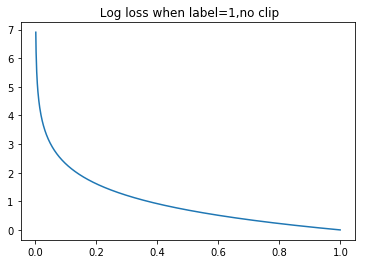

0.0010005003335835344 6.907755278982137 0.9907007467084084


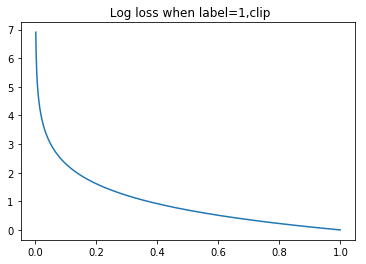

In [51]:
ans = [logloss(1,pred) for pred in np.arange(0.001,1,0.001)]

print(min(ans),max(ans),np.mean(ans[1:]))
plt.plot(np.arange(0.001,1,0.001),ans)
plt.title(' Log loss when label=1,no clip')
plt.show()

ans = [logloss(1,pred,True) for pred in np.arange(0.001,1,0.001)]

print(min(ans),max(ans),np.mean(ans[1:]))
plt.plot(np.arange(0.001,1,0.001),ans)
plt.title(' Log loss when label=1,clip')
plt.show()

-0.0 6.907755278982136 0.9956271004939736


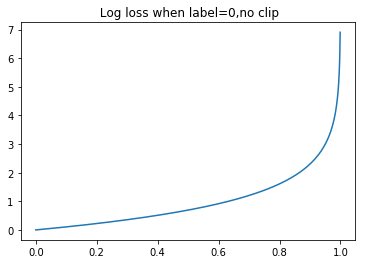

9.992007221626415e-16 6.907755278982136 0.9956271004939736


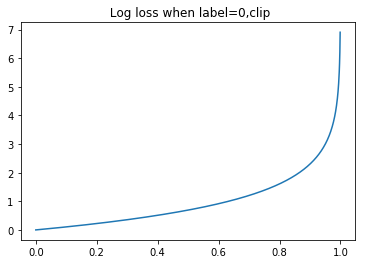

In [52]:
ans = [logloss(0,pred) for pred in np.arange(0,1,0.001)]

print(min(ans),max(ans),np.mean(ans))
plt.plot(np.arange(0,1,0.001),ans)
plt.title(' Log loss when label=0,no clip')
plt.show()

ans = [logloss(0,pred,True) for pred in np.arange(0,1,0.001)]

print(min(ans),max(ans),np.mean(ans))
plt.plot(np.arange(0,1,0.001),ans)
plt.title(' Log loss when label=0,clip')
plt.show()

we can find:  
1. log loss的最大值为正无穷，最小值为0  
2. 对于每次预测，只有正确样本的预测误差会计入最后的损失
3. log loss在正确分类时末尾的变化是非常缓慢的，但是在错误分类时loss会急剧增大。即log loss对过于自信的错误预测的punish要大于自信的正确预测的收益，所以通常对pred进行clip。